In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

import numpy as np
from scipy.spatial.distance import cdist
from scipy import stats

import cv2
from PIL import Image
from skimage.segmentation import slic
from skimage import io
from skimage import img_as_float

import os
from itertools import product
import sys
sys.path.insert(0, '/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/')
from network.rtpose_vgg import get_model
from network.post import decode_pose, plot_pose
from training.datasets.coco_data.preprocessing import (inception_preprocess,
                                              rtpose_preprocess,
                                              ssd_preprocess, vgg_preprocess)



In [ ]:
(0-'nose'	1-'neck' 
2-'' 3-'right_elbow' 4-'right_wrist'
5-''  6-'left_elbow'  7-'left_wrist'  
8-'right_hip'      9-'right_knee'  10-'right_ankle'	
11-'left_hip'      12-'left_knee'  13-'left_ankle'
14-'right_eye'	   15-'left_eye'   
16-'right_ear'     17-'left_ear'

In [2]:
right_shoulder = 2
left_shoulder = 5
right_hip = 8
left_hip = 11
right_knee = 9
left_knee = 12
UPPER = [2, 5, 8, 11]
THIGH1 = [8, 9]
THIGH2 = [11, 12]

In [9]:
def load_pose_model():
    model = get_model('vgg19') 
    weight_name = '/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/network/pose_model_scratch.pth'
    checkpoint = torch.load(weight_name)
    model_dict = model.state_dict()
    ckpt = {k.replace("module.", ""): v for k, v in checkpoint.items() if k.replace("module.", "") in model_dict and torch.isnan(v).sum() == 0}
    model_dict.update(ckpt)
    model.load_state_dict(model_dict)
    model = model.cuda()
    # model.float()
    model.eval()
    return model

class COLORS():
    BGR = np.array([[int(b),int(g),int(r)] for b,g,r in product([0,255],repeat = 3)])
    H = np.array([[  10000.],
                    [  0.],
                    [120.],
                    [ 60.],
                    [240.],
                    [ 44.],
                    [180.],
                    [  10000.],
                    [  10000.]])
    
    def __init__(self):
        self.color_names = ['Black',
                            'Red',
                            'Green',
                            'Yellow',
                            'Blue',
                            'Magenta',
                            'Aqua',
                            'Gray',
                            'White']        
        self.color_np = [(int(b),int(g),int(r)) for b,g,r in product([0,255],repeat = 3)]
    def get_color(self, c):
        return self.color_names[c]
    def get_color_value(self, c):
        return self.color_np[c]

Color = COLORS()

def get_pose(model, img):    
    pil_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    pil_img = Image.fromarray(pil_img)    
        
    batch_var = trans(pil_img).unsqueeze(0).cuda()
    with torch.no_grad():
        predicted_outputs, _ = model(batch_var)

    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
    paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

    real_shape = img.shape

    heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    paf = paf[0:real_shape[0], 0:real_shape[1], :]
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    candidate, subset = decode_pose(
        img, param, heatmap, paf)  
    
    return subset, candidate

def get_sample_points(img, person, candidate, part=UPPER):
    samples = []
    points = []
    if (person[part] > 0).sum() == len(part):              

        x_coord1 = np.linspace(candidate[int(person[right_shoulder])][0], 
                              candidate[int(person[left_hip])][0], num=10).astype(int)
        y_coord1 = np.linspace(candidate[int(person[right_shoulder])][1], 
                              candidate[int(person[left_hip])][1], num=10).astype(int)
        x_coord2 = np.linspace(candidate[int(person[left_shoulder])][0], 
                              candidate[int(person[right_hip])][0], num=10).astype(int)
        y_coord2 = np.linspace(candidate[int(person[left_shoulder])][1], 
                              candidate[int(person[right_hip])][1], num=10).astype(int)
        
        for x, y in zip(x_coord1, y_coord1):
            samples.append(img[y, x, :])            
        for x, y in zip(x_coord2, y_coord2):
            samples.append(img[y, x, :])
        points = [np.concatenate([x_coord1, x_coord2]), np.concatenate([y_coord1, y_coord2])]
    samples = np.array(samples)
    points = np.transpose(np.array(points))
    
    return samples, points

def get_color(orig, samples, points, plot=False, use_hsv=False):
    h, w = orig.shape[:2]    
    to_plot = orig.copy() 
    
    if use_hsv:
        n = samples.shape[0]
        if (samples[:,2] < 40).sum() > n/2:
            mode = 0
        else:
            if (samples[:,1] > 50).sum() < n/2:
                if (samples[:,2] < 90).sum() > n/2:
                    mode = 7
                else:
                    mode = 8
            else:
                dist = cdist(samples[:,0][:,np.newaxis], Color.H).argmin(axis=1)
                mode = stats.mode(dist)[0][0]              
    else:
        dist = cdist(samples, Color.BGR).argmin(axis=1)
        mode = stats.mode(dist)[0][0]    
    
    color = Color.get_color(mode)
    if plot:
        for x, y in points:
            cv2.circle(to_plot, (x,y), 4, Color.get_color_value(mode), thickness=-1)
            
    return color, to_plot

def superpixelize(img, path, use_hsv=False):
    image = io.imread(path)
    segments = slic(img_as_float(image), n_segments=150,slic_zero=True)
    to_plot = img.copy()
    for v in np.unique(segments):
        # construct a mask for the segment so we can compute image
        # statistics for *only* the masked region
        if use_hsv:
            temp = to_plot[:,:,0]
            avg = temp[segments == v].mean()
            temp[segments == v] = avg
            to_plot[:,:,0] = temp
        else:
            for i in range(3):
                temp = to_plot[:,:,i]
                avg = temp[segments == v].mean()
                temp[segments == v] = avg
                to_plot[:,:,i] = temp
    return to_plot

def to_normal_hsv(cv_HSV):
    cv_HSV[...,0] *= 2 
    cv_HSV[...,1] = cv_HSV[...,1] / 2.55 
    cv_HSV[...,2] = cv_HSV[...,2] / 2.55 
    
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

NameError: name 'UPPER' is not defined

In [4]:
model = load_pose_model()

Bulding VGG19


In [54]:
test = np.zeros_like(img)
test[...,0] = 0
test[...,1] = 0
test[...,2] = 255
test = test.astype(np.uint8)
ycc_img = cv2.cvtColor(test, cv2.COLOR_BGR2YCR_CB)
ycc_img[0].mean(axis=0)

array([ 76., 255.,  85.])

In [16]:
img_as_float(img)

array([[[0.43921569, 0.44313725, 0.19215686],
        [0.42745098, 0.43137255, 0.18039216],
        [0.4627451 , 0.4745098 , 0.23137255],
        ...,
        [0.83921569, 0.92156863, 0.90980392],
        [0.83921569, 0.92156863, 0.90980392],
        [0.83921569, 0.92156863, 0.90980392]],

       [[0.40392157, 0.37647059, 0.12941176],
        [0.40784314, 0.38823529, 0.14117647],
        [0.40784314, 0.38823529, 0.14901961],
        ...,
        [0.83921569, 0.92156863, 0.90980392],
        [0.83529412, 0.91764706, 0.90588235],
        [0.83529412, 0.91764706, 0.90588235]],

       [[0.52156863, 0.43529412, 0.20784314],
        [0.49411765, 0.41568627, 0.18823529],
        [0.49803922, 0.41960784, 0.19215686],
        ...,
        [0.84313725, 0.9254902 , 0.91372549],
        [0.84313725, 0.9254902 , 0.91372549],
        [0.83921569, 0.92156863, 0.90980392]],

       ...,

       [[0.56470588, 0.49411765, 0.46666667],
        [0.56470588, 0.49411765, 0.46666667],
        [0.56078431, 0

In [14]:
io.imread(path).shape

(450, 173, 3)

In [10]:
# path = "/media/allen/mass/reid/26th/bounding_box_test/001_c103s1_000269_04.jpg"
path = "/media/allen/mass/reid/sogo/bounding_box_train/9999_c1s1_0_01.jpg"
img = cv2.imread(path)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv = True
subset, candidate = get_pose(model, img)
to_normal_hsv(hsv_img)

NameError: name 'model' is not defined

In [39]:
sample_img = superpixelize(hsv_img, path)
usamples, upoints = get_sample_points(sample_img, subset[0], candidate, part=UPPER)
l1samples, l1points = get_sample_points(sample_img, subset[0], candidate, part=THIGH1)
l2samples, l2points = get_sample_points(sample_img, subset[0], candidate, part=THIGH2)
lsamples = np.concatenate([l1samples, l2samples])
lpoints = np.concatenate([l1points, l2points])

In [40]:
usamples

array([[204,  56,  45],
       [235,  77,  36],
       [237,  77,  36],
       [237,  77,  36],
       [235,  77,  35],
       [235,  77,  35],
       [238,  74,  34],
       [238,  74,  34],
       [239,  73,  34],
       [237,  73,  34],
       [225,  64,  32],
       [236,  75,  35],
       [236,  75,  35],
       [237,  74,  34],
       [237,  75,  34],
       [237,  75,  34],
       [238,  74,  34],
       [237,  74,  34],
       [237,  74,  34],
       [238,  72,  34]], dtype=uint8)

In [34]:
l1samples

array([[204,  56,  45],
       [235,  77,  36],
       [237,  77,  36],
       [237,  77,  36],
       [235,  77,  35],
       [235,  77,  35],
       [238,  74,  34],
       [238,  74,  34],
       [239,  73,  34],
       [237,  73,  34],
       [225,  64,  32],
       [236,  75,  35],
       [236,  75,  35],
       [237,  74,  34],
       [237,  75,  34],
       [237,  75,  34],
       [238,  74,  34],
       [237,  74,  34],
       [237,  74,  34],
       [238,  72,  34]], dtype=uint8)

In [43]:
ucolor, uto_plot = get_color(img, usamples, upoints, plot=True, use_hsv=True)
lcolor, lto_plot = get_color(img, lsamples, lpoints, plot=True, use_hsv=True)
print(ucolor, lcolor)

Black Black


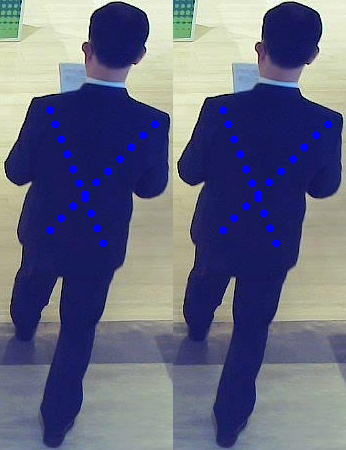

In [31]:
temp = cv2.cvtColor(uto_plot, cv2.COLOR_BGR2RGB)    
upil_img = Image.fromarray(temp)
temp = cv2.cvtColor(lto_plot, cv2.COLOR_BGR2RGB)    
lpil_img = Image.fromarray(temp)
pil_img = get_concat_h(upil_img, lpil_img)
pil_img

In [27]:
subset[0][THIGH1]

array([ 9., 10.])

In [201]:
import os.path as osp

In [373]:
src = "/media/allen/mass/reid/sogo/bounding_box_train/"
dst = "/media/allen/mass/sogo_color_superpixel"
imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])

In [374]:
for path in imgs_path:
    img = cv2.imread(path)    
    subset, candidate = get_pose(model, img)
    to_plot = superpixelize(img, path)        
    l, u, plot = get_upper_color(img, to_plot, subset[0], candidate, plot=True)    
    path = osp.basename(path)
    if l is not None:
        if not osp.exists(osp.join(dst, 'lower', l)):
            os.makedirs(osp.join(dst, 'lower', l))
        cv2.imwrite(osp.join(dst, 'lower', l, path), plot)
    if u is not None:
        if not osp.exists(osp.join(dst, 'upper', u)):
            os.makedirs(osp.join(dst, 'upper', u))
        cv2.imwrite(osp.join(dst, 'upper', u, path), plot)
#     break

In [176]:
get_upper_color(img, subset[0], candidate, plot=True)

array([0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4])

In [387]:
image = io.imread(path)
segments = slic(img_as_float(image), n_segments=150,slic_zero=True)
to_plot = img.copy()
for v in np.unique(segments):
    # construct a mask for the segment so we can compute image
    # statistics for *only* the masked region
    for i in range(3):
        temp = to_plot[:,:,i]
        avg = temp[segments == v].mean()
        temp[segments == v] = avg
        to_plot[:,:,i] = temp
    

In [280]:
subset, candidate = get_pose(model, img)
l, u, plot = get_upper_color(to_plot, subset[0], candidate, plot=True)

'blue'

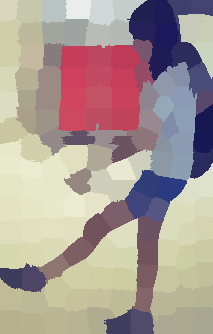

In [388]:
temp = cv2.cvtColor(to_plot, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [19]:
import sys
sys.path.insert(0, '/media/allen/mass/deep-learning-works/')
from app.Person_Search import App
from config.config_manager import _C as model_config
from config.config_manager import _A as app_config

model_config.merge_from_file("/media/allen/mass/deep-learning-works/reid_app.yml")
app_config.merge_from_file("/media/allen/mass/deep-learning-works/app.yml")

In [20]:
app = App(model_config, app_config)

2019-11-14 11:06:48,894 logger INFO: Using GPU: 1
2019-11-14 11:06:49,031 logger INFO: Resuming model from /media/allen/mass/deep-learning-works/caffe_models/OSNet_merge_cels_triplet_center_Adam_lr_0.003_warmup_10_0.01_plateau_10_flip_crop_erase_imagenet_0.7096.pth
2019-11-14 11:06:49,071 logger INFO: opt_0 is skipped
2019-11-14 11:06:49,072 logger INFO: opt_1 is skipped
2019-11-14 11:06:49,075 logger INFO: model backbone.conv1.conv.weight                              ...... loaded
2019-11-14 11:06:49,076 logger INFO: model backbone.conv1.bn.weight                                ...... loaded
2019-11-14 11:06:49,077 logger INFO: model backbone.conv1.bn.bias                                  ...... loaded
2019-11-14 11:06:49,077 logger INFO: model backbone.conv1.bn.running_mean                          ...... loaded
2019-11-14 11:06:49,078 logger INFO: model backbone.conv1.bn.running_var                           ...... loaded
2019-11-14 11:06:49,079 logger INFO: model backbone.conv2.0.c

2019-11-14 11:06:49,131 logger INFO: model backbone.conv2.0.conv2d.2.bn.running_var                ...... loaded
2019-11-14 11:06:49,131 logger INFO: model backbone.conv2.0.conv2d.3.conv1.weight                  ...... loaded
2019-11-14 11:06:49,132 logger INFO: model backbone.conv2.0.conv2d.3.conv2.weight                  ...... loaded
2019-11-14 11:06:49,133 logger INFO: model backbone.conv2.0.conv2d.3.bn.weight                     ...... loaded
2019-11-14 11:06:49,134 logger INFO: model backbone.conv2.0.conv2d.3.bn.bias                       ...... loaded
2019-11-14 11:06:49,134 logger INFO: model backbone.conv2.0.conv2d.3.bn.running_mean               ...... loaded
2019-11-14 11:06:49,135 logger INFO: model backbone.conv2.0.conv2d.3.bn.running_var                ...... loaded
2019-11-14 11:06:49,136 logger INFO: model backbone.conv2.0.gate.fc1.weight                        ...... loaded
2019-11-14 11:06:49,136 logger INFO: model backbone.conv2.0.gate.fc1.bias                       

2019-11-14 11:06:49,193 logger INFO: model backbone.conv2.1.conv2d.0.bn.running_var                ...... loaded
2019-11-14 11:06:49,194 logger INFO: model backbone.conv2.1.conv2d.1.conv1.weight                  ...... loaded
2019-11-14 11:06:49,195 logger INFO: model backbone.conv2.1.conv2d.1.conv2.weight                  ...... loaded
2019-11-14 11:06:49,196 logger INFO: model backbone.conv2.1.conv2d.1.bn.weight                     ...... loaded
2019-11-14 11:06:49,197 logger INFO: model backbone.conv2.1.conv2d.1.bn.bias                       ...... loaded
2019-11-14 11:06:49,197 logger INFO: model backbone.conv2.1.conv2d.1.bn.running_mean               ...... loaded
2019-11-14 11:06:49,198 logger INFO: model backbone.conv2.1.conv2d.1.bn.running_var                ...... loaded
2019-11-14 11:06:49,199 logger INFO: model backbone.conv2.1.conv2d.2.conv1.weight                  ...... loaded
2019-11-14 11:06:49,200 logger INFO: model backbone.conv2.1.conv2d.2.conv2.weight               

2019-11-14 11:06:49,251 logger INFO: model backbone.conv3.0.conv2c.1.bn.running_var                ...... loaded
2019-11-14 11:06:49,252 logger INFO: model backbone.conv3.0.conv2c.2.conv1.weight                  ...... loaded
2019-11-14 11:06:49,253 logger INFO: model backbone.conv3.0.conv2c.2.conv2.weight                  ...... loaded
2019-11-14 11:06:49,253 logger INFO: model backbone.conv3.0.conv2c.2.bn.weight                     ...... loaded
2019-11-14 11:06:49,254 logger INFO: model backbone.conv3.0.conv2c.2.bn.bias                       ...... loaded
2019-11-14 11:06:49,255 logger INFO: model backbone.conv3.0.conv2c.2.bn.running_mean               ...... loaded
2019-11-14 11:06:49,256 logger INFO: model backbone.conv3.0.conv2c.2.bn.running_var                ...... loaded
2019-11-14 11:06:49,257 logger INFO: model backbone.conv3.0.conv2d.0.conv1.weight                  ...... loaded
2019-11-14 11:06:49,258 logger INFO: model backbone.conv3.0.conv2d.0.conv2.weight               

2019-11-14 11:06:49,313 logger INFO: model backbone.conv3.1.conv2b.1.bn.running_var                ...... loaded
2019-11-14 11:06:49,314 logger INFO: model backbone.conv3.1.conv2c.0.conv1.weight                  ...... loaded
2019-11-14 11:06:49,314 logger INFO: model backbone.conv3.1.conv2c.0.conv2.weight                  ...... loaded
2019-11-14 11:06:49,319 logger INFO: model backbone.conv3.1.conv2c.0.bn.weight                     ...... loaded
2019-11-14 11:06:49,320 logger INFO: model backbone.conv3.1.conv2c.0.bn.bias                       ...... loaded
2019-11-14 11:06:49,320 logger INFO: model backbone.conv3.1.conv2c.0.bn.running_mean               ...... loaded
2019-11-14 11:06:49,321 logger INFO: model backbone.conv3.1.conv2c.0.bn.running_var                ...... loaded
2019-11-14 11:06:49,322 logger INFO: model backbone.conv3.1.conv2c.1.conv1.weight                  ...... loaded
2019-11-14 11:06:49,323 logger INFO: model backbone.conv3.1.conv2c.1.conv2.weight               

2019-11-14 11:06:49,379 logger INFO: model backbone.conv4.0.conv2a.bn.running_var                  ...... loaded
2019-11-14 11:06:49,379 logger INFO: model backbone.conv4.0.conv2b.0.conv1.weight                  ...... loaded
2019-11-14 11:06:49,380 logger INFO: model backbone.conv4.0.conv2b.0.conv2.weight                  ...... loaded
2019-11-14 11:06:49,381 logger INFO: model backbone.conv4.0.conv2b.0.bn.weight                     ...... loaded
2019-11-14 11:06:49,381 logger INFO: model backbone.conv4.0.conv2b.0.bn.bias                       ...... loaded
2019-11-14 11:06:49,382 logger INFO: model backbone.conv4.0.conv2b.0.bn.running_mean               ...... loaded
2019-11-14 11:06:49,383 logger INFO: model backbone.conv4.0.conv2b.0.bn.running_var                ...... loaded
2019-11-14 11:06:49,384 logger INFO: model backbone.conv4.0.conv2b.1.conv1.weight                  ...... loaded
2019-11-14 11:06:49,385 logger INFO: model backbone.conv4.0.conv2b.1.conv2.weight               

2019-11-14 11:06:49,443 logger INFO: model backbone.conv4.0.downsample.bn.running_mean             ...... loaded
2019-11-14 11:06:49,444 logger INFO: model backbone.conv4.0.downsample.bn.running_var              ...... loaded
2019-11-14 11:06:49,444 logger INFO: model backbone.conv4.1.conv1.conv.weight                      ...... loaded
2019-11-14 11:06:49,445 logger INFO: model backbone.conv4.1.conv1.bn.weight                        ...... loaded
2019-11-14 11:06:49,446 logger INFO: model backbone.conv4.1.conv1.bn.bias                          ...... loaded
2019-11-14 11:06:49,447 logger INFO: model backbone.conv4.1.conv1.bn.running_mean                  ...... loaded
2019-11-14 11:06:49,447 logger INFO: model backbone.conv4.1.conv1.bn.running_var                   ...... loaded
2019-11-14 11:06:49,448 logger INFO: model backbone.conv4.1.conv2a.conv1.weight                    ...... loaded
2019-11-14 11:06:49,449 logger INFO: model backbone.conv4.1.conv2a.conv2.weight                 

2019-11-14 11:06:49,498 logger INFO: model backbone.conv4.1.gate.fc1.weight                        ...... loaded
2019-11-14 11:06:49,499 logger INFO: model backbone.conv4.1.gate.fc1.bias                          ...... loaded
2019-11-14 11:06:49,500 logger INFO: model backbone.conv4.1.gate.fc2.weight                        ...... loaded
2019-11-14 11:06:49,500 logger INFO: model backbone.conv4.1.gate.fc2.bias                          ...... loaded
2019-11-14 11:06:49,501 logger INFO: model backbone.conv4.1.conv3.conv.weight                      ...... loaded
2019-11-14 11:06:49,505 logger INFO: model backbone.conv4.1.conv3.bn.weight                        ...... loaded
2019-11-14 11:06:49,506 logger INFO: model backbone.conv4.1.conv3.bn.bias                          ...... loaded
2019-11-14 11:06:49,508 logger INFO: model backbone.conv4.1.conv3.bn.running_mean                  ...... loaded
2019-11-14 11:06:49,509 logger INFO: model backbone.conv4.1.conv3.bn.running_var                

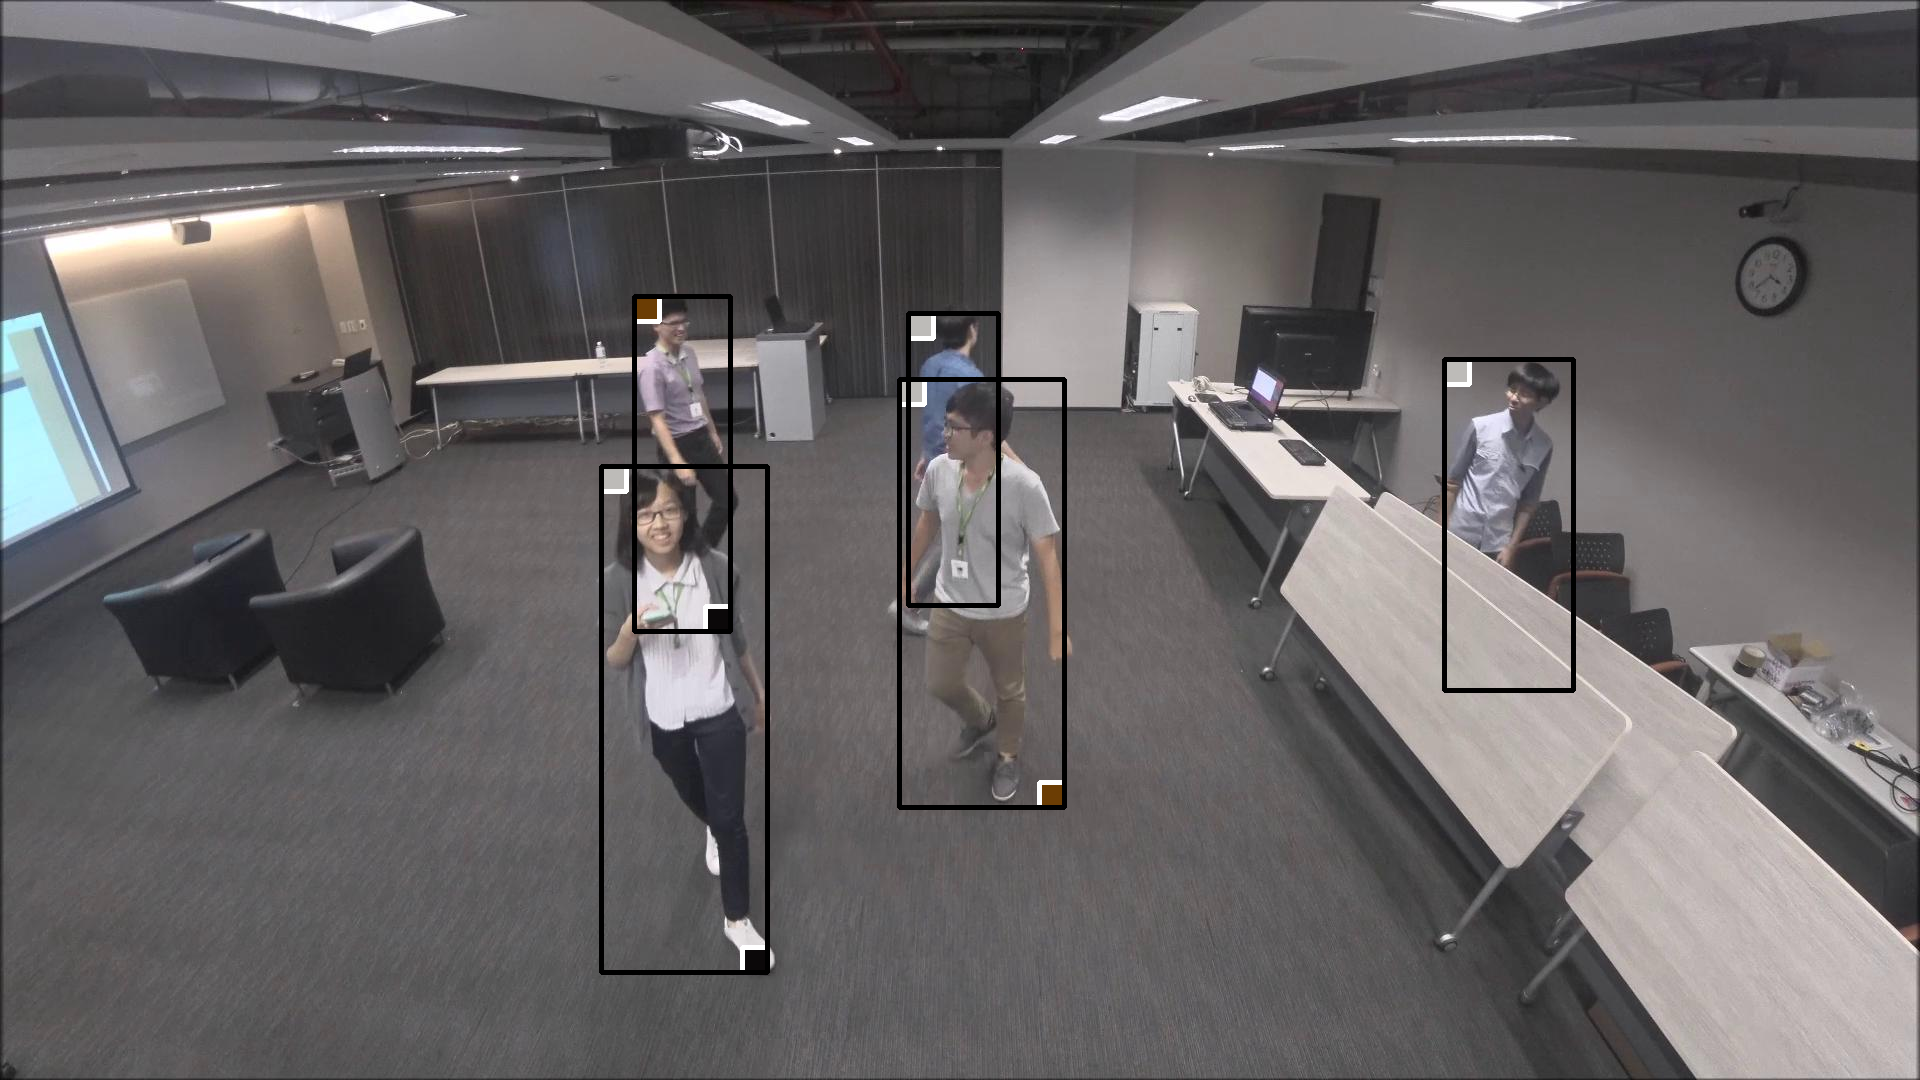

In [23]:
inputs = app.get_input()
det = app.get_det(inputs)

app.get_colors()
plot = app.render()
app.update()
import cv2
from PIL import Image
temp = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [10]:
app.people.df

,img,id,bbox,uc,uci,lc,lci
1,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,1,"[669, 10, 770, 316]",gray,6,gray,6
1,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,1,"[693, 0, 784, 319]",blue,2,gray,6
2,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,2,"[886, 1, 962, 123]",none,-1,none,-1
1,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,1,"[688, 1, 789, 313]",blue,2,gray,6
1,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,1,"[854, 24, 1014, 395]",gray,6,gray,6
2,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,2,"[680, 2, 780, 321]",blue,2,gray,6
3,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,3,"[626, 0, 699, 298]",none,-1,blue,2
4,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,4,"[962, 15, 1035, 154]",none,-1,none,-1
1,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,1,"[689, 1, 786, 318]",blue,2,gray,6
2,/media/allen/mass/sogo/testing/JPEGImages/A1_2...,2,"[845, 2, 906, 176]",none,-1,none,-1


In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import cv2
import re
import numpy as np
import os
import os.path as osp

In [5]:
df = pd.read_csv("/media/allen/mass/26th_color/people.csv", index_col=[0], dtype={'img':str, 'bbox':str, 'id':int, 'uc':str, 'lc':str, 'uci':int, 'lci':int})

In [6]:
df.uc.unique()

array(['gray', 'brown', 'blue', 'black', 'none'], dtype=object)

In [4]:
def get_group(_df, dst):
    pattern = re.compile(r'\[(\d+), (\d+), (\d+), (\d+)\]')
    for idx in range(_df.shape[0]):
        path = _df.iloc[idx].img
        pid = _df.iloc[idx].id
        x1, y1, x2, y2 = [i for i in map(int, pattern.search(_df.iloc[idx].bbox).groups())]
        img = cv2.imread(path)
        crop = img[y1:y2, x1:x2, :]
        c_h, c_w = crop.shape[:2]
        i_h, i_w = img.shape[:2]
        c_r = 300.0 / c_h
        c_w = int(c_w * c_r)
        i_r = 300.0 / i_h
        i_w = int(i_w * i_r)
        crop = cv2.resize(crop, (c_w, 300))
        cv2.rectangle(img, (x1, y1), (x2, y2), (255,255,255), 3)
        img = cv2.resize(img, (i_w, 300))
        merge_img = np.zeros((300, c_w+i_w, 3))
        merge_img[:, :c_w, :] = crop
        merge_img[:, c_w:, :] = img
        merge_img = merge_img.astype(np.uint8)
        path = osp.basename(path)
        fname, ext = osp.splitext(path)    
        fname = "{}_{}{}".format(fname, pid, ext)        
        fname = osp.join(dst, fname)
        cv2.imwrite(fname, merge_img)

In [49]:
df = pd.read_csv("/media/allen/mass/26th_color/people.csv", index_col=[0], dtype={'img':str, 'bbox':str, 'id':int, 'uc':str, 'lc':str, 'uci':int, 'lci':int})
for c in df.uc.unique():
    if c != 'none':
        print("All detected upper color : {}".format(c))
for c in df.lc.unique():
    if c != 'none':
        print("All detected lower color : {}".format(c))
        
dst = osp.join(dst, part, request)
if not osp.exists(dst):
    os.makedirs(dst)

if u_request == 'F' and l_request != 'F':
    _df = df[df.lc==request]
    get_group(_df, dst)
elif u_request != 'F' and l_request == 'F':
    _df = df[df.lc==request]
    get_group(_df, dst)
else:
    print("Unsupported clothing part: {}".format(part))



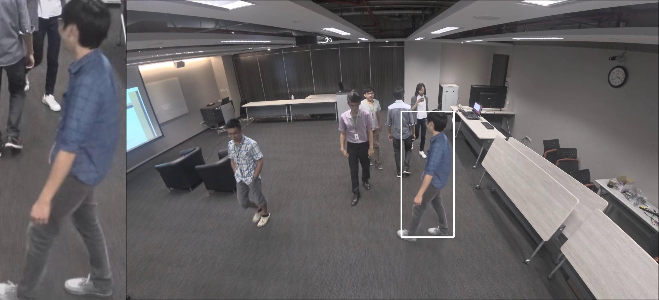

In [40]:
temp = cv2.cvtColor(merge_img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(temp)
pil_img

In [14]:
_df.iloc[idx].bbox

'[991, 401, 1181, 853]'